# Constructing an Object with Point Cloud Data

This notebook goes over how to take a sample image that has an object of interest in it, along with point cloud data, and generate a mesh representation of that object.

The steps are as follow:

1. First we crop the point cloud data so it matches the RGB image it's assocciated with, in terms of PoV.
2. Then we can also rotate it as well to show how the point cloud data matches the image.
3. Next we further crop it to remove noise.
4. However, noise can be detected better through object segmentation, so we do that which also identifies our object for us.
5. With the object obtained from clustering, we create a 3D reconstruction.
6. We also get an approximate measure of the size (diameter, height) of the object, and it's distance from a reference point.
7. Then we texturize the 3D reconstructed object with the RGB image.
8. Finally, we export it in TIF format (float32, LZW compression) in 0.2m resolution.

First we start with some imports (that don't already exist normally in Google Colab).

In [ ]:
!pip install open3d rasterio removebg

Importing all necessary libraries here now.

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
from removebg import RemoveBg
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
import rasterio
from rasterio.transform import from_origin

To follow along with this notebook, make sure the point cloud data file is in the local directory with the name `sample_input.pcd`, and the corresponding image as well, with the name `input.png`.

In [ ]:
point_cloud = o3d.io.read_point_cloud("sample_input.pcd")
print(point_cloud)

PointCloud with 262144 points.


In [ ]:
points = np.asarray(point_cloud.points)
points.shape

(262144, 3)

We can visualize the whole point cloud data here. Note we use the draw_plotly function throughout this notebook, which is not as well supported, but is the simplest option to work within notebooks. Also note that when loading the whole pcd file it may take some time.

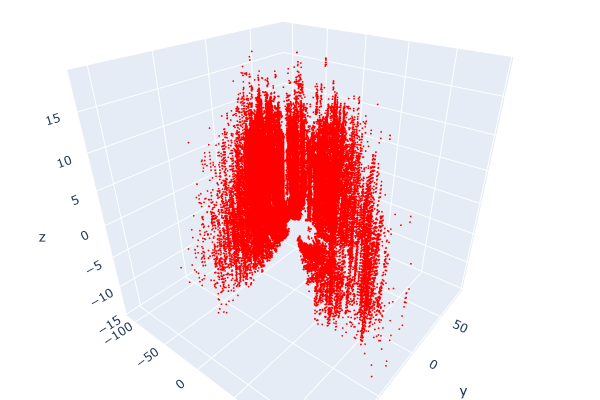

In [ ]:
# Uncomment to see interactive plot, or simply view the screenshot
#o3d.visualization.draw_plotly([point_cloud])

display(Image.open("raw_pcd.png"))

From manual inspection you can see the coordinates of the object in the image have ranges of:

- x: [-5, 0]
- y: [1, 2]
- z: [-1.5, 1.5]

Thus, we should crop according to these numbers. Let's start by narrowing in on it first.

## Cropping Original Data

We'll just crop with arbitrarily smaller values to get in close and inspect further. We can create a bounding box for the point cloud data visualization with min and max coordinate values.

In [ ]:
crop_min = [-25, -25, -25]  # x_min, y_min, z_min
crop_max = [25, 25, 25]    # x_max, y_max, z_max

In [ ]:
bbox = o3d.geometry.AxisAlignedBoundingBox(crop_min, crop_max)
cropped_pcd = point_cloud.crop(bbox)

In this plot the main object can be seen but it is still small.

**Note**: we will show the plots via screenshots to make sure they are saved and rendered well, but you can also run the code below to visualize interactive plots.

In [ ]:
# Uncomment to run, or just take a look at the screenshot below
#o3d.visualization.draw_plotly([cropped_pcd])

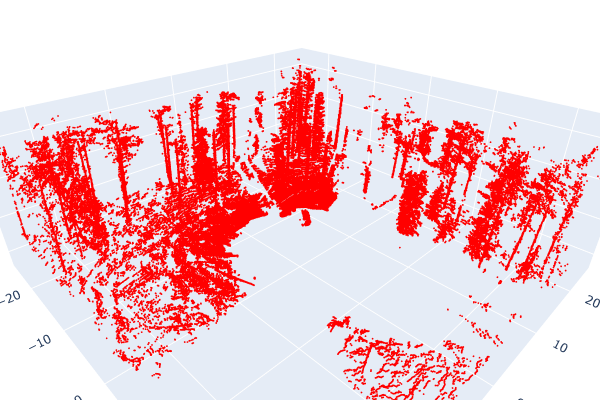

In [ ]:
image = Image.open("crop1.png")
display(image)

## Adjusting PoV Rotation

We want it to be a close match to the image so from this we should crop the image so that the max x value of the object is the max x bound. And similarly for z.

For y, we should use a value a bit to the right of the object, going farther to the left for the minimum.

In [ ]:
crop_min = [-20, -8, -4]  # x_min, y_min, z_min
crop_max = [-1, 6, 1.2]    # x_max, y_max, z_max

bbox = o3d.geometry.AxisAlignedBoundingBox(crop_min, crop_max)
cropped_pcd = point_cloud.crop(bbox)

In [ ]:
# Uncomment to run, or just look at the screenshot below
#o3d.visualization.draw_plotly([cropped_pcd])

You can see below a screenshot but this time next to the RGB input image - this time they match a lot better.

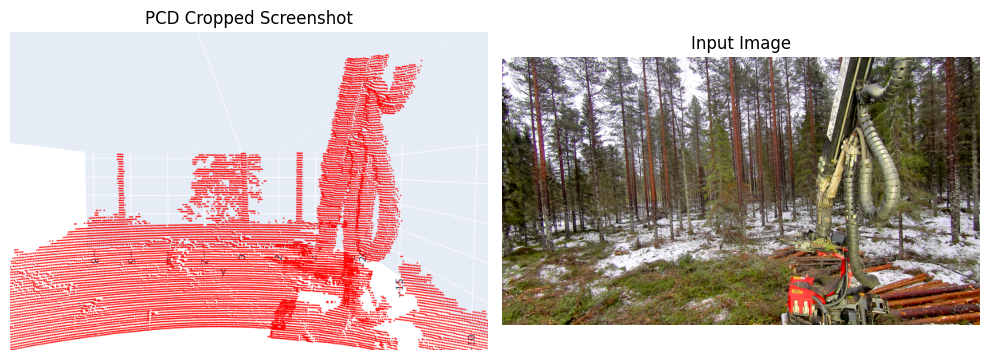

In [ ]:
# Load the images
image1 = Image.open("crop2.png")  # Replace with your first image path
image2 = Image.open("input.png")  # Replace with your second image path

# Create a Matplotlib figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first image
axes[0].imshow(np.array(image1))  # Convert PIL Image to NumPy array
axes[0].axis("off")  # Hide axes
axes[0].set_title("PCD Cropped Screenshot")  # Set title

# Display the second image
axes[1].imshow(np.array(image2))
axes[1].axis("off")
axes[1].set_title("Input Image")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

To adjust the PoV, we simply rotated the view in the interative plot. Unfortunately, Open3D does not allow to save the new PoV when you modify it in the interactive plot. To achieve this without manual work or any trial and error, you would need some extra information when collecting the point cloud data - things like the a camera's intrinsic and extrinsic parameters (e.g. focal lengths, translation vectors). That way you could algorithmically adjust the point cloud data's point of view to be the same as the image.

## Terrain Filtration

To focus more on looking only at the terrain points, we can shift the x-axis a bit, as the trees are further out in this image. We might also want to increase the z_max a bit just to see the trees a bit more as they are much taller than in the actual image (as they are cut off by the camera view).

In [ ]:
crop_min_terrain_focus = [-55, -8, -4]  # x_min, y_min, z_min
crop_max_terrain_focus = [-5, 6, 2]    # x_max, y_max, z_max

bbox_terrain_focus = o3d.geometry.AxisAlignedBoundingBox(crop_min_terrain_focus, crop_max_terrain_focus)
cropped_pcd_terrain_focus = point_cloud.crop(bbox_terrain_focus)

In [ ]:
# Uncomment to see interactive display, or simply view the screenshot below
#o3d.visualization.draw_plotly([cropped_pcd_terrain_focus])

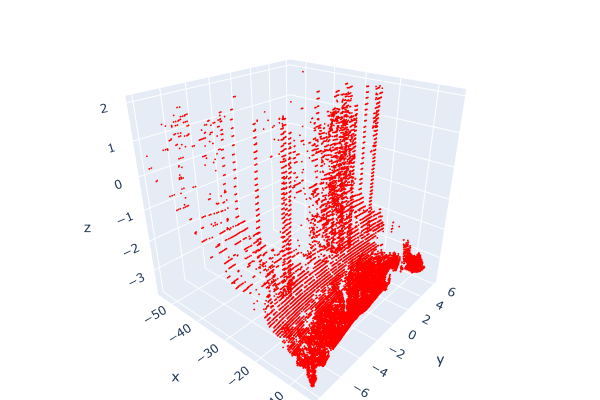

In [ ]:
display(Image.open("crop3.png"))

So now you can see the terrain points separately, where it's clear the object is on a hill, and the trees are quite tall. You can also see the point cloud is quite sparse further out, which doesn't seem to reflect the input image - likely an issue or result in the point cloud data collection method.

In any case, while we can do some basic cropping to see the terrain points, accomplishing actual Terrain Filtration requires a bit more work. To implement it, we need to completely single out the ground which will essentially act as a plane in 3D space.


In [ ]:
terrain_and_trees = np.asarray(cropped_pcd.points)

### Filtering Terrain Points

So here we filter the terrain points completely from any other points (in this case, again, just trees). We do this by:

1. **Height Thresholding**: Remove points above a certain height (z-value) threshold to exclude objects clearly not part of the terrain. We'll use a threshold value of 60% here.

2. **Normal Estimation**: Normals are estimated for each point in the cloud based on its local neighborhood. This helps identify the orientation of the surface at each point.

3. **Slope Filtering**: The Z-component of the normals (`vertical_normals`) is used to identify flat terrain. Points with nearly vertical slopes (e.g., trees) are excluded.

4. **Filtering Flat Terrain**: Points with a Z-normal component greater than `0.9` are considered part of the flat terrain, while others (e.g., trees) are removed.

5. **Output**: The filtered terrain points are saved as a new point cloud (`filtered_terrain.pcd`) and, once again, you can simply view a screenshot, or view the interactive plot but following along with the notebook.


In [ ]:
z_percentage_threshold = 60
z_threshold = np.percentile(terrain_and_trees[:, 2], z_percentage_threshold)

# Now filter out points outside of the threshold
terrain_indices = np.where(terrain_and_trees[:, 2] <= z_threshold)[0]
terrain_points = terrain_and_trees[terrain_indices]

Now get the new point cloud.

In [ ]:
terrain_pcd = o3d.geometry.PointCloud()
terrain_pcd.points = o3d.utility.Vector3dVector(terrain_points)

In [ ]:
o3d.io.write_point_cloud("terrain_only.pcd", terrain_pcd)
# Uncomment to visualize, but it's essentially the same as the above image.
#o3d.visualization.draw_plotly([terrain_pcd])

True

Next let's get the normals and compute the slope.

In [ ]:
# Estimate normals for slope filtering
terrain_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30))

# Compute slope (z-difference between neighbors)
normals = np.asarray(terrain_pcd.normals)
vertical_normals = np.abs(normals[:, 2])  # Z-normal component (1 for flat terrain, < 1 for trees)

Now let's filter it and save this output.

In [ ]:

# Filter points with near-vertical slopes (trees)
flat_terrain_indices = np.where(vertical_normals > 0.6)[0]  # Adjust threshold for flatness
flat_terrain_points = np.asarray(terrain_pcd.points)[flat_terrain_indices]

# Create the filtered terrain point cloud
filtered_terrain_pcd = o3d.geometry.PointCloud()
filtered_terrain_pcd.points = o3d.utility.Vector3dVector(flat_terrain_points)

# Save or visualize
o3d.io.write_point_cloud("filtered_terrain.pcd", filtered_terrain_pcd)


True

And we can view the result here. This point cloud data is a bit noisy though, so when looking directly at the terrain it won't appear as you wold expect unless you zoom out a bit. We can do this in a notebook by customizing our view with plotly.

In [ ]:
# Convert Open3D point cloud to numpy array
points = np.asarray(filtered_terrain_pcd.points)

# Create a custom Plotly scatter plot for 3D visualization
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode="markers",
            marker=dict(size=2, color=points[:, 2], colorscale="Viridis", opacity=0.8),
        )
    ]
)

# Adjust the 3D layout to zoom out, we'll zoom out by 5 units
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[points[:, 0].min() - 5, points[:, 0].max() + 5], title="X-Axis"),
        yaxis=dict(range=[points[:, 1].min() - 5, points[:, 1].max() + 5], title="Y-Axis"),
        zaxis=dict(range=[points[:, 2].min() - 5, points[:, 2].max() + 5], title="Z-Axis"),
    ),
    title="Terrain Point Cloud Visualization",
)

fig.show()


The below image is a screenshot of the output from the above code cell, although again this plot is an interactive 3D plot. Note the color is only different thanks to plotly's customization capabilities.

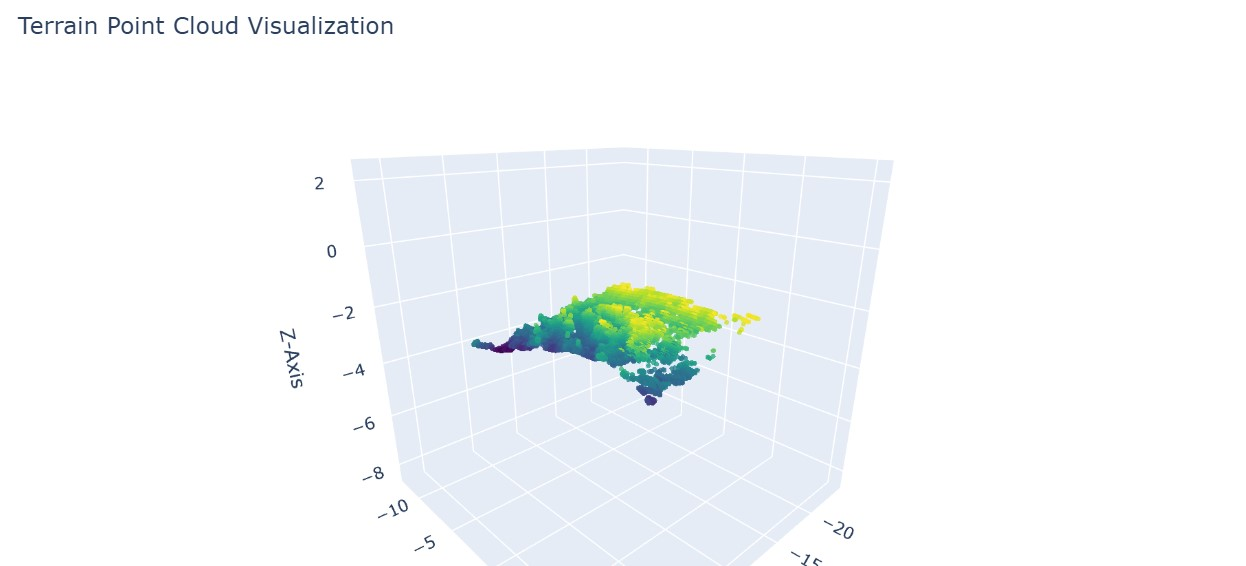

In [ ]:
display(Image.open("terrain_point_cloud_viz.png.jpg"))

## Object Segmentation

Now to both clear out noise in a more systematic way, and identify what is what in the point cloud data, we can do object segmentation via clustering. In this case, we will use dbscan which comes out of the box in Open3D.

You can find the documentation here:

https://www.open3d.org/docs/latest/tutorial/geometry/pointcloud.html#DBSCAN-clustering.

To get the corrent number of clusters, you can use intuition and trial and error with the parameters here. The `eps` parameter here is the radius around a point within which other points are considered neighbours (in the same cluster), and the `min_points` is the number of points a point needs at minimum to be considered a core point in a cluster (a point the forms the center of the cluster).

In [ ]:
labels = np.array(cropped_pcd.cluster_dbscan(
    eps=0.9,
    min_points=50,
    print_progress=True
    )
)

The labels for each cluster will be integers, including 0. One exception exists, however, which is the noise, which will be labelled with -1.

Thus we can get the total number of clusters by taking the max of the labels an adding 1.

In [ ]:
max_label = labels.max()

print(f"Point cloud has {max_label + 1} clusters")

Point cloud has 2 clusters


Now let's plot the data and visualize how well it did.

In [ ]:
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0  # Noise points
cropped_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [ ]:
# Visualize the clustered point cloud, uncomment to see it,
# or just take a look at the screenshot below

#o3d.visualization.draw_plotly([cropped_pcd])

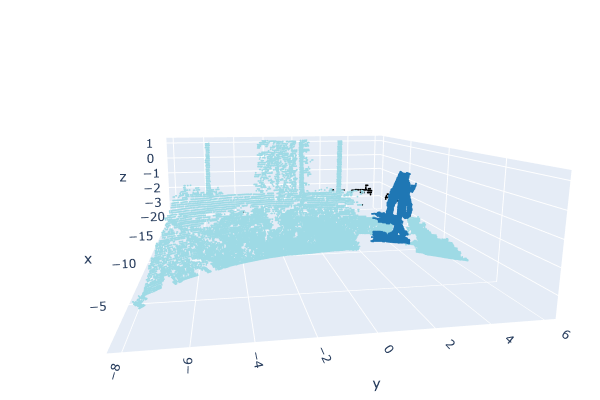

In [ ]:
display(Image.open("dbscan1.png"))

You can clearly see it did a good job. The object of interest is in blue, while the terrain and trees is in light blue. There is also a bit of noise in black, but it is negligible.

That being said, you can also plot the noise separately.

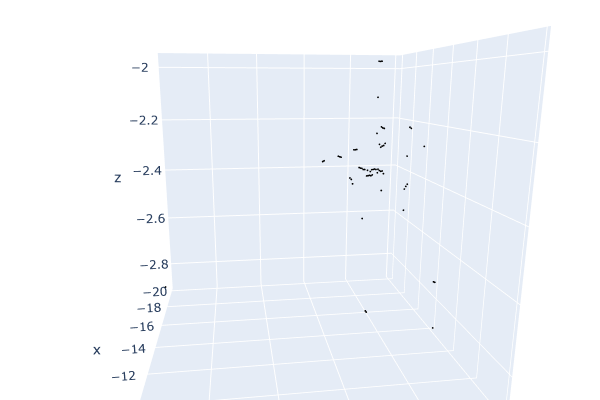

In [ ]:
noise_indices = np.where(labels == -1)[0] #Open3D DBScan labels noise as -1
noise_points = cropped_pcd.select_by_index(noise_indices)

# Take a look at the screenshot, or uncomment to view an interactive plot
#noise_points.paint_uniform_color([0, 0, 0])  # Black for noise
#o3d.visualization.draw_plotly([noise_points])

display(Image.open("dbscan1_noise.png"))

### Singling out the Objects

Alternatively, you can also configure the parameters to label the terrain as noise, and treat this as a class. This might be better as then, for other images with multiple objects, as you can iterate through each cluster, which will be separate objects, without having to worry about the terrain as it was labelled as noise.

Also, we already have the terrain data saved from above if we need it, so here we can safely modify our parameters so that only objects are clusters, and everything else is noise.

In [ ]:
labels = np.array(cropped_pcd.cluster_dbscan(eps=0.5, min_points=500, print_progress=True))

In [ ]:
max_label = labels.max()

print(f"Point cloud has {max_label + 1} clusters")

Point cloud has 1 clusters


Since the terrain is now left as noise, we have only one cluster as expected. Also, we don't have to worry about other random noisy points not being captured by DBScan.

In [ ]:
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0  # Noise points
cropped_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# Uncomment to visualize the clustered point cloud
#o3d.visualization.draw_plotly([cropped_pcd])

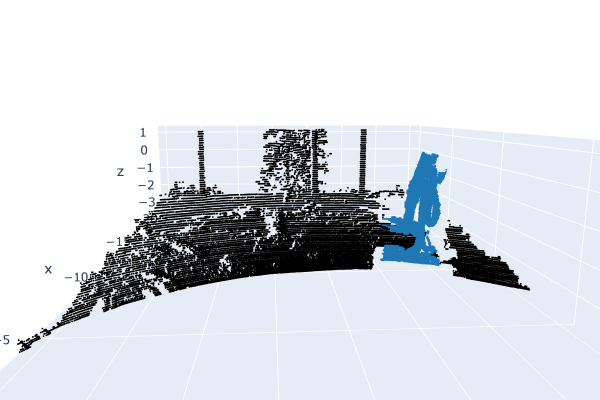

In [ ]:
display(Image.open("dbscan2.png"))

The convenience of  setting the terrain to noise is that we can iterate through each cluster know they are all objects of interest now. In this case, we only have one, so this was just a bonus here.

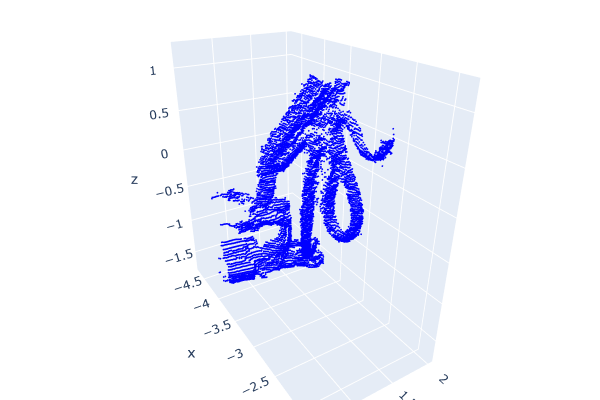

In [ ]:
# the above comment refers to this line of code, where if you had multiple objects, you could iterated over them with a for loop
object_indices = np.where(labels == 0)[0]  # We only have 1 cluster, with label 0
object_pcd = cropped_pcd.select_by_index(object_indices)

# Ucomment to visualize the object separately
#object_pcd.paint_uniform_color([0, 0, 1])  # Red for the object
#o3d.visualization.draw_plotly([object_pcd])

display(Image.open("dbscan2_object.png"))

We will need this later though so let's save it.

In [ ]:
o3d.io.write_point_cloud("object_point_cloud.ply", object_pcd)

True

## 3D Reconstruction

when it comes to point cloud data, 3D reconstruction typically involves creating a mesh object, which we can do with a few methods. Poisson reconstruction is a common one, but we will use Alpha Shape reconstruction which is simpler.

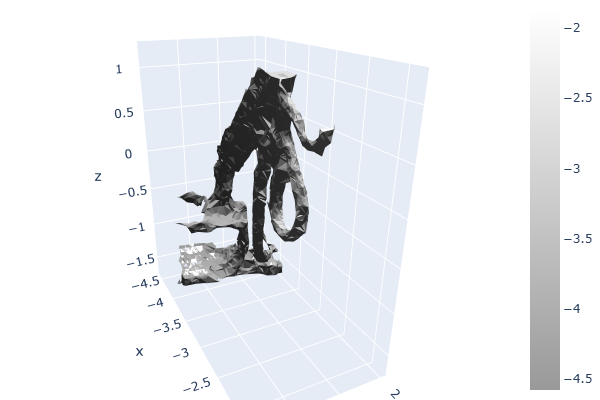

In [ ]:
alpha = 0.08  # Adjust alpha for tighter or looser fitting
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(object_pcd, alpha)

# Uncomment to visualize the Alpha Shape mesh
#mesh.compute_vertex_normals()
#o3d.visualization.draw_plotly([mesh])

display(Image.open("mesh1.png"))

## Size Calculation

To calcualte size here means the height and diameter. Height is obvious, but for diameter, the typical definition for complex objects is the largest horizontal span an object taks.

### Height and Diameter

We can get the height easily by getting the bounding box defined by the object.

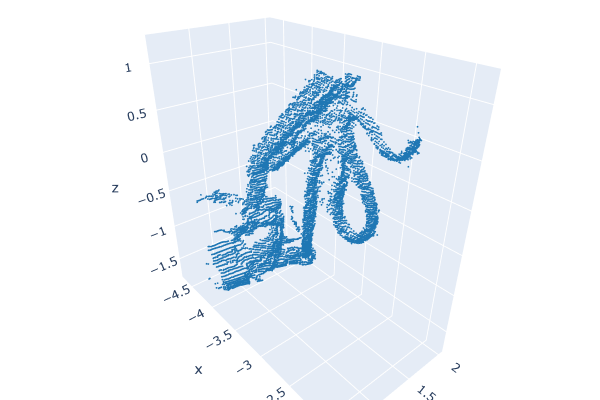

In [ ]:
bbox = object_pcd.get_axis_aligned_bounding_box()

# Uncomment to visualize the bounding box with the object
#bbox.color = (1, 0, 0)  # Red for the bounding box
#o3d.visualization.draw_plotly([object_pcd, bbox])

display(Image.open("bounding_box.png"))

# Get the dimensions of the bounding box
extents = bbox.get_extent()

Then the height is just the height of the bounding box.

In [ ]:
height = round(extents[2], 2)
print(f"Height: {height}")

Height: 2.9


Now, to calculate the object's diameter, we:

1. **Extract XY Coordinates**: Focused on the horizontal plane by using only the `XY` coordinates of the points.
2. **Compute the Convex Hull**: Found the smallest convex polygon enclosing all points to define the object's boundary.
3. **Calculate the Diameter**: Measured the maximum distance between any two points on the Convex Hull.
4. **Visualize**: Plotted the Convex Hull over the original points to verify the calculation, with the diameter displayed in the title.

We can use SciPy libaries to do this quite easily.

In [ ]:
# Step 1: Extract XY coordinates
points_xy = np.asarray(object_pcd.points)[:, :2]  # Only X and Y coordinates

# Step 2: Compute the Convex Hull
hull = ConvexHull(points_xy)
hull_points = points_xy[hull.vertices]

# Step 3: Compute the Diameter
distances = pdist(hull_points)
diameter = round(distances.max(), 2)  # Round to the nearest hundredth
print(f'The diameter is: {diameter}')

The diameter is: 2.83


We can plot this as well to see how it looks.

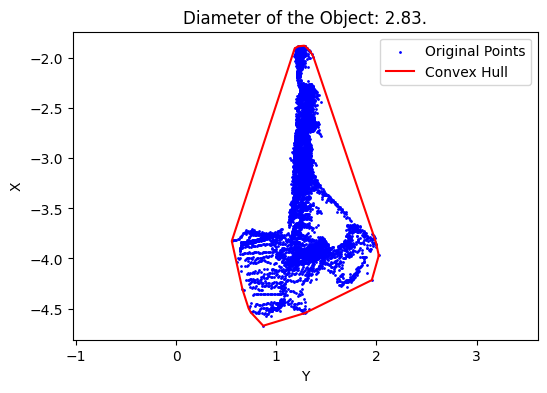

In [ ]:
# Step 4: Plot the Points and Convex Hull
plt.figure(figsize=(6, 4))

# Plot the original points with X and Y swapped
plt.scatter(points_xy[:, 1], points_xy[:, 0], color="blue", s=1, label="Original Points")

# Plot the convex hull with X and Y swapped
plt.plot(
    np.append(hull_points[:, 1], hull_points[0, 1]),  # Swap X and Y
    np.append(hull_points[:, 0], hull_points[0, 0]),  # Swap X and Y
    color="red",
    label="Convex Hull",
)

# Add labels and title
plt.xlabel("Y")
plt.ylabel("X")
plt.title(f"Diameter of the Object: {diameter}.")
plt.legend()
plt.axis("equal")
plt.show()


### Distance from Reference Point

The distance would normally be the distance from the camera to the object. But we don't have data or information on the camera or it's location, so here is just a method to calculate the distance from any reference point.

This is simply a distance calcualte between the centroid of the object and the given reference point (or typically camera location).

In [ ]:
# Compute centroid of the object
points = np.asarray(object_pcd.points)
centroid = points.mean(axis=0)
print(f"Centroid of the object: {centroid}")


Centroid of the object: [-3.24181453  1.26638501 -0.16283058]


In [ ]:
camera_position = np.array([0, 0, 0])  # Replace with actual camera position if known
distance = round(np.linalg.norm(centroid - camera_position), 2)
print(f"Distance from the camera: {distance}")

Distance from the camera: 3.48


## Texturizing

Texturizing using the input 2D image with a 3D mesh object is not easy as we would need more information about the camera, such as its intrinsic parameters (focal length, principal point, distortion) and extrinsic parameters (position and orientation relative to the object). Without these, aligning the image accurately with the mesh requires manual adjustments or approximations, which can introduce errors in the texture mapping process.

Moreover, we can't get camera view from the interactive plotly.open3d plots either, so we can't make use of those for makeshift focal lengths, etc.

Regardless, we can still do it with a more tedious and manual method, using Blender, which you can download here: [Blender Download](https://www.blender.org/download/).

### Steps to Align the Point Cloud in Blender

1. **Import the Point Cloud Data:**
   - Open Blender.
   - Go to `File > Import > Stanford (.ply)` and select your point cloud file (exported as `.ply`).
   - The point cloud will appear in the 3D viewport.

2. **Align the Object with the Image:**
   - On the right panel, switch to the `Image Editor`.
   - Import the input RGB image to see it side-by-side with the point cloud data.
   - Adjust the **Object Mode** to rotate, scale, and position the point cloud so it aligns with the image on the XY plane.

3. **Export the Aligned Point Cloud:**
   - Once the point cloud is aligned with the image, go to `File > Export > Stanford (.ply)` to save the updated point cloud.

By aligning the point cloud in Blender, we ensure the object is properly oriented relative to the 2D image, making it easier to project and apply the texture in subsequent steps. See the screenshot below for an idea of what you should have.


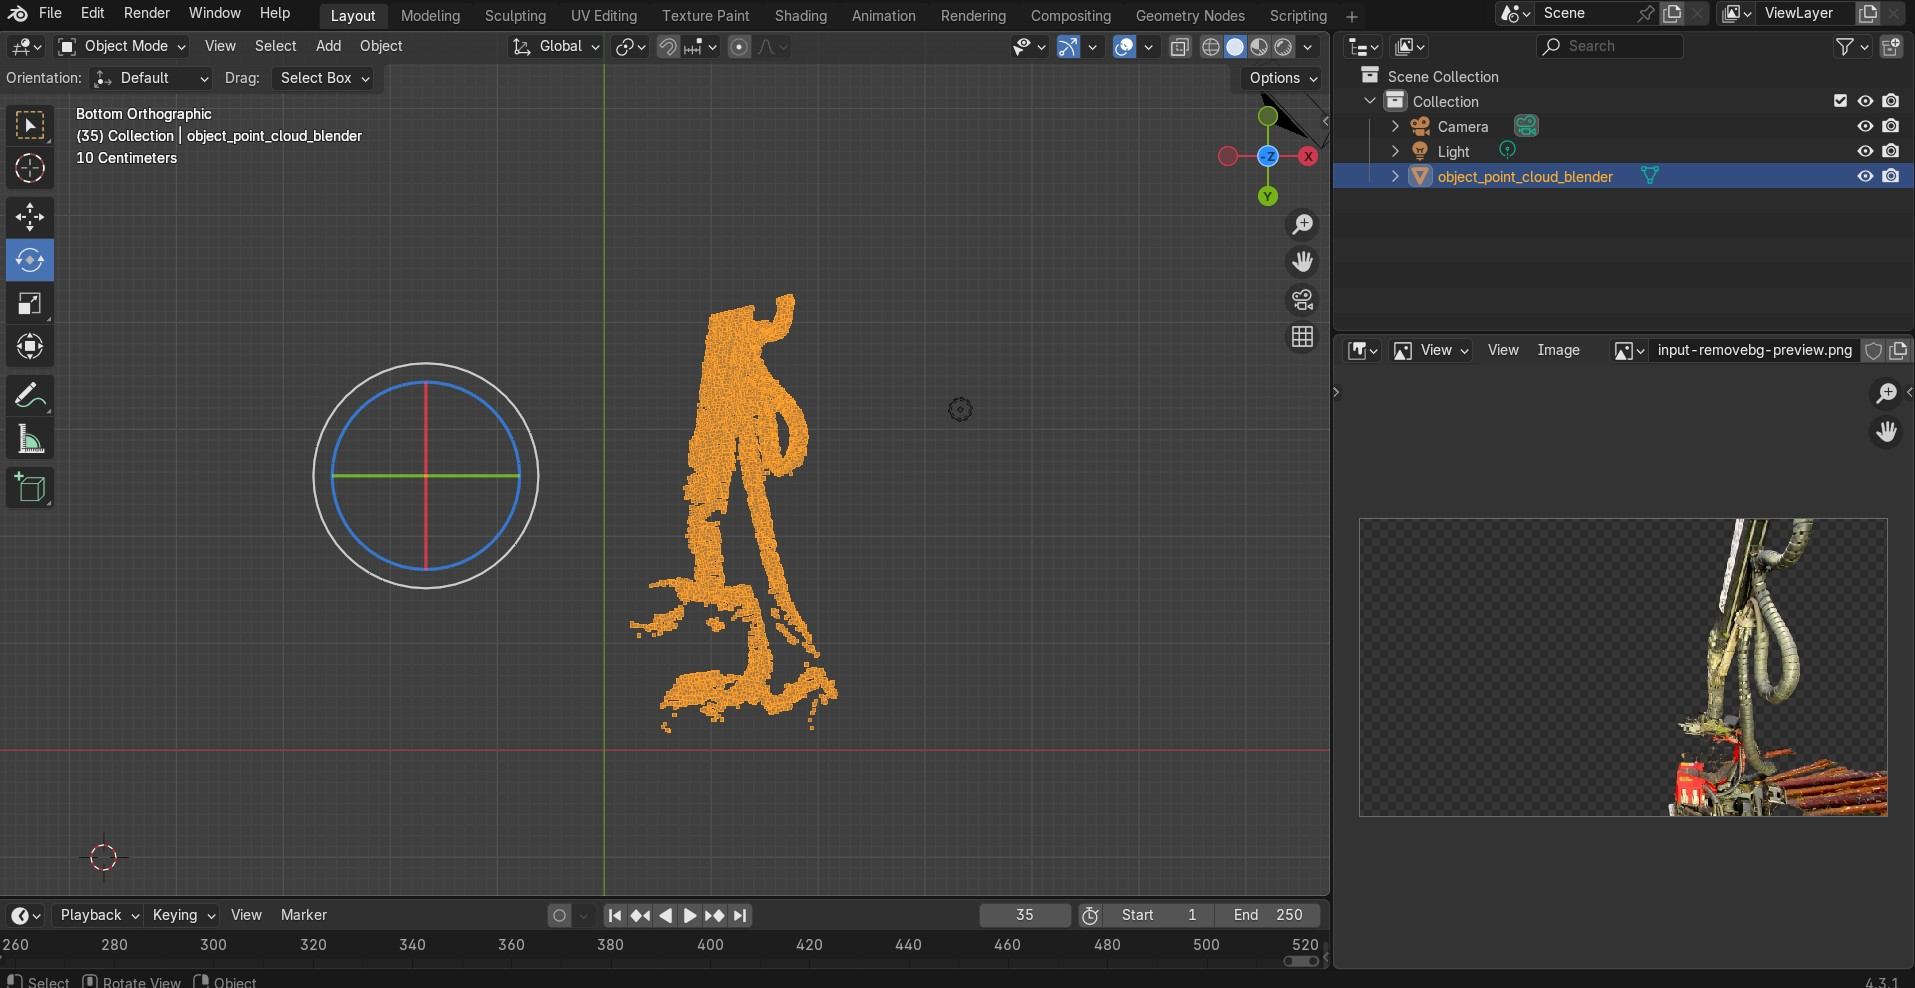

In [ ]:
display(Image.open("blender_pcd_screenshot.jpg"))

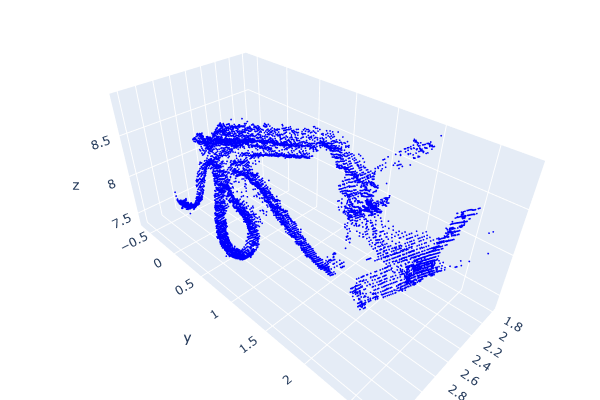

In [ ]:
# Umcomment to visualize the interactive plot, or simply view the screenshot
blender_point_cloud = o3d.io.read_point_cloud("object_point_cloud_blender7.ply")
#o3d.visualization.draw_plotly([blender_point_cloud])
display(Image.open("blender_export.png"))

Now here we project the point cloud data from the exported object to the 2d plane and plot them to show what it looks like on it's own. Remember, since we aligned the object in the XY plane in Blender, it should resemble the object in it's projection.

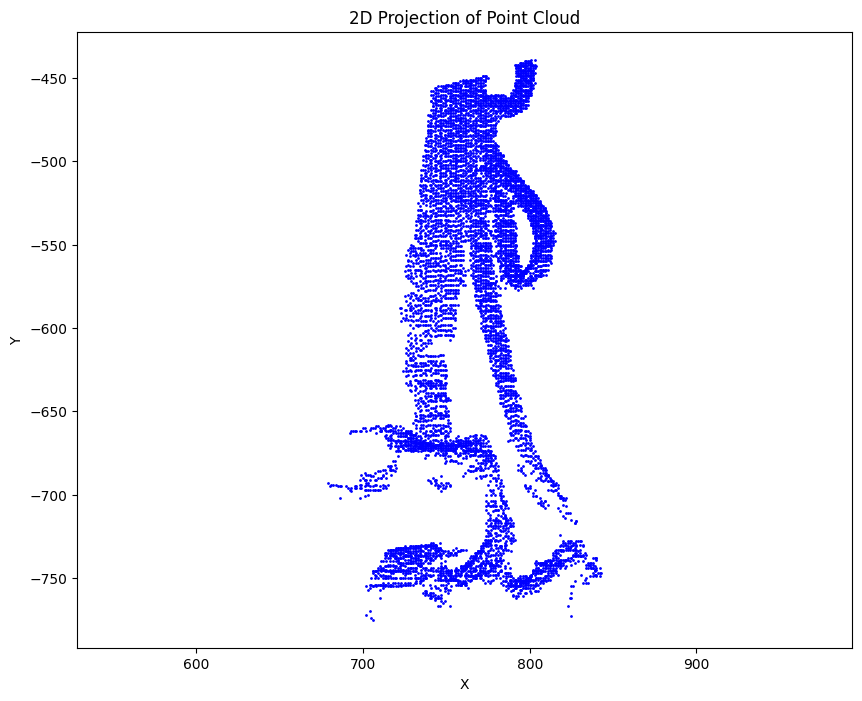

In [ ]:
# Convert point cloud to NumPy array
points = np.asarray(blender_point_cloud.points)

# Define projection parameters
# Scale and offsets to map 3D coordinates to 2D image space
scale = 100  # Adjust scale to fit the 2D plot
offset_x, offset_y = 500, 500  # Center the points in the image

# Project 3D points to 2D (orthographic projection: ignore depth)
u = (points[:, 0] * scale + offset_x).astype(int)  # X to horizontal axis
v = (points[:, 1] * scale + offset_y).astype(int)  # Y to vertical axis

# Plot the 2D projection
plt.figure(figsize=(10, 8))
plt.scatter(u, -v, s=1, c="blue")  # Flip v-axis for correct orientation
plt.title("2D Projection of Point Cloud")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()


While not necessary, we can also remove the background of the input image to make it more clear what's going on, as we will plot the projected data on top of the image to make sure it is well aligned.

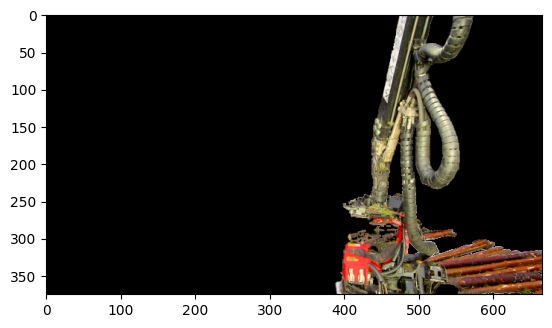

In [ ]:
# Initialize the Remove.bg API with your API key
rmbg = RemoveBg("your_removebg_api_key", "output_directory")

rmbg.remove_background_from_img_file("input.png")

image = cv2.imread("input.png_no_bg.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

Now here we are projecting the data again but with customized offsets and scale values. We get them with trial and error, trying to fit the projected points as well as we can onto the 3d Object.

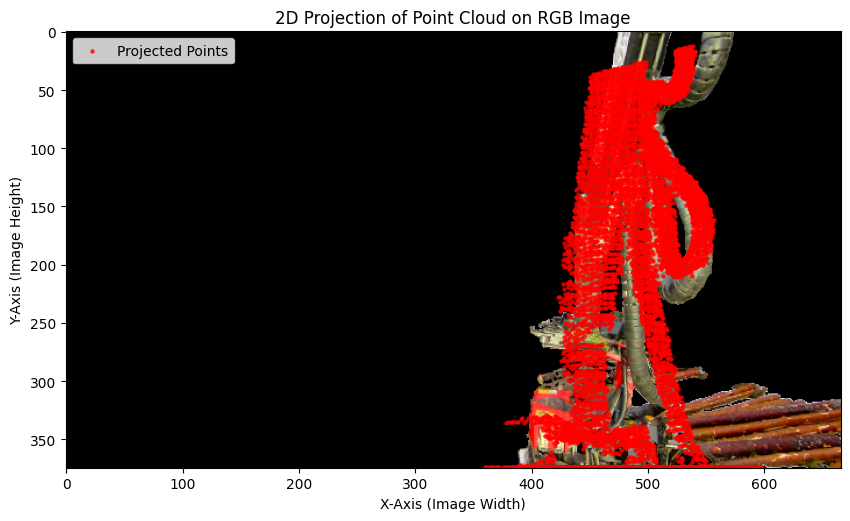

In [ ]:
# Load the RGB image
image = cv2.imread("input.png_no_bg.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB
image_height, image_width, _ = image.shape

# Load the point cloud
blender_point_cloud = o3d.io.read_point_cloud("object_point_cloud_blender7.ply")
points = np.asarray(blender_point_cloud.points)

# Define projection parameters
scale = 145  # Scale factor to map 3D coordinates to image pixels
offset_x, offset_y = 100, 100  # Center the points in the image

# Project 3D points to 2D
u = (points[:, 0] * scale + offset_x).astype(int)  # Map X to horizontal axis
v = (points[:, 1] * scale + offset_y).astype(int)  # Map Y to vertical axis

# Clamp points to stay within image bounds
u = np.clip(u, 0, image_width - 1)
v = np.clip(v, 0, image_height - 1)

# Plot the image with the projected points
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.scatter(u, v, s=5, c='red', alpha=0.7, label="Projected Points")  # Flip v-axis for correct orientation
plt.title("2D Projection of Point Cloud on RGB Image")
plt.xlabel("X-Axis (Image Width)")
plt.ylabel("Y-Axis (Image Height)")
plt.legend()
plt.show()


You can see it's not a perfect match, and it probably is not possible to obtain a perfect match without going back to Blender. There are also better alternative tools to handle 3d data that could work here, but unfortunately they are not python or, more specifically, jupyter notebook friendly.

Regardless, we'll note them here:

1. **Open3D**:
   - A powerful library for working with point clouds, meshes, and 3D geometry.
   - Ideal for automated workflows, custom algorithms, and programmatic visualization.
2. **PyVista**:
   - A Python wrapper for VTK, great for 3D visualization and mesh manipulation.
   - User-friendly and integrates well with scientific Python tools like NumPy and Matplotlib.
3. **Trimesh**:
   - Lightweight and efficient for 3D mesh processing, including slicing, repairing, and exporting.
   - Highly recommended for analysis and programmatic mesh handling.

Now, moving on, with these projected points at least somewhat lined up with the RGB image, we can at least use what we have. So we will take the points that intersect with the object (something we can only do since we removed the background), and take the objects pixel value at that point. This will then give us the colors to map to the point cloud data.


In [ ]:
colors = image[v, u]
colors = colors[:, :3] / 255.0

In [ ]:
blender_point_cloud.colors = o3d.utility.Vector3dVector(colors)

In [ ]:
o3d.io.write_point_cloud("textured_point_cloud.ply", blender_point_cloud)

print("Textured point cloud saved as textured_point_cloud.ply.")

Textured point cloud saved as textured_point_cloud.ply.


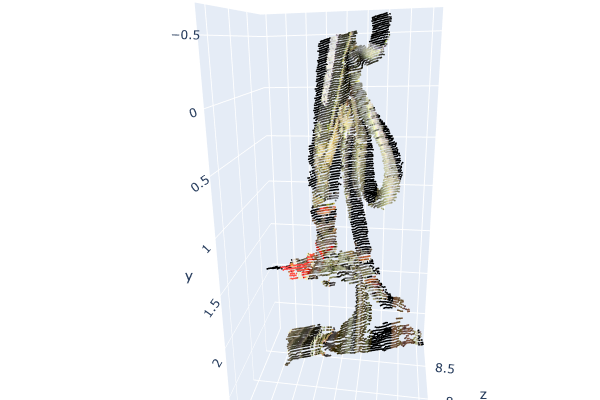

In [ ]:
blender_point_cloud = o3d.io.read_point_cloud("textured_point_cloud.ply")
#o3d.visualization.draw_plotly([blender_point_cloud]) # uncomment to visualize interactive plot

display(Image.open('texturized_pcd.png'))

So it actually still looks pretty decent. This is texturized point cloud data though, what most people would probably interested in is the texturized mesh, so let's do that next.

Instead of points we have vertices to assign colors to. So basically we repeat the same process as above but with the vertices instead of points, but otherwise it is all the same.

In [ ]:
# Create a mesh from the point cloud
alpha = 0.03  # Adjust alpha value as needed for your mesh
final_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    blender_point_cloud,
    alpha
)

# Get the vertices of the mesh
vertices = np.asarray(final_mesh.vertices)  # Shape (num_vertices, 3)

# Project vertices to 2D image space
u = (vertices[:, 0] * scale + offset_x).astype(int)  # X to horizontal axis
v = (vertices[:, 1] * scale + offset_y).astype(int)  # Y to vertical axis

# Clamp the coordinates to the image bounds
u = np.clip(u, 0, image_width - 1)
v = np.clip(v, 0, image_height - 1)

# Extract colors from the image
vertex_colors = image[v, u]  # Extract RGB values for each vertex
vertex_colors = vertex_colors[:, :3] / 255.0  # Normalize to [0, 1]

# Assign the vertex colors to the mesh
final_mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)

# Save the textured mesh
o3d.io.write_triangle_mesh("final_textured_mesh.ply", final_mesh)
print("Textured mesh saved as final_textured_mesh.ply.")

Textured mesh saved as final_textured_mesh.ply.


Unfortunately, we can't save view the colored mesh in notebook easily with Opend3D. So we have to use the following work around, but know that it is otherwise simpler.

In [ ]:
# Convert vertex colors (numeric) to Plotly-compatible RGB format
def to_rgb_string(color):
    r, g, b = (color * 255).astype(int)
    return f"rgb({r}, {g}, {b})"

# Create per-triangle color mapping
triangle_colors = []
triangles = np.asarray(final_mesh.triangles)

# Assign a color to each triangle based on the average vertex color
for i, j, k in triangles:
    avg_color = np.mean([vertex_colors[i], vertex_colors[j], vertex_colors[k]], axis=0)
    triangle_colors.append(to_rgb_string(avg_color))

# Plot with Plotly
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            i=triangles[:, 0],
            j=triangles[:, 1],
            k=triangles[:, 2],
            facecolor=triangle_colors,  # Use actual RGB colors for each triangle
            flatshading=True,
        )
    ]
)

# Uncomment for interactive plot, otherwise view the screenshot below
"""
fig.update_layout(
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    title="Textured Mesh (RGB Colors)",
)
fig.show()
"""


'\nfig.update_layout(\n    scene=dict(\n        xaxis=dict(title="X"),\n        yaxis=dict(title="Y"),\n        zaxis=dict(title="Z"),\n    ),\n    title="Textured Mesh (RGB Colors)",\n)\nfig.show()\n'

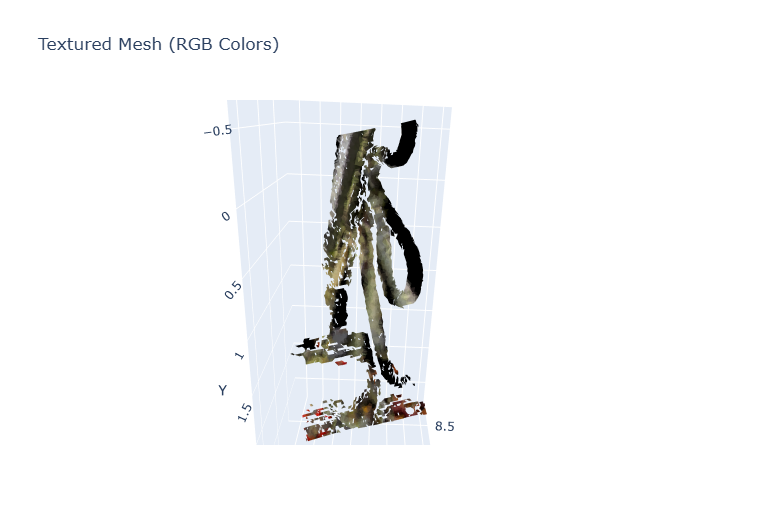

In [ ]:
display(Image.open("texturized_mesh.png"))

## Exporting in TIF

This code creates a heightmap from a 3D mesh and saves it as a GeoTIFF file with a 0.2m resolution and compression.

1. **Load the Mesh**:
   - The 3D mesh is loaded from a `.ply` file, and its vertex coordinates are extracted.

2. **Define Grid Resolution**:
   - A grid resolution of 0.2m (as specified) is used to create a regular grid over the `X` and `Y` coordinates of the mesh.

3. **Interpolate Heights**:
   - The `Z` values (heights) of the vertices are projected onto the grid.
   - For each vertex, the corresponding grid cell is identified, and the `Z` value is assigned to it.

4. **Handle Missing Values**:
   - Any grid cells without an assigned height (NaN) are filled using the average height of the mesh to ensure completeness.

5. **Save as GeoTIFF**:
   - The heightmap is saved as a GeoTIFF file using the `rasterio` library:
     - **Float32**: Ensures high precision for the height values.
     - **LZW Compression**: Reduces file size without losing data.
     - **Transform**: Maps the grid to the real-world `X` and `Y` coordinates.


In [ ]:
# Load the mesh
final_mesh = o3d.io.read_triangle_mesh("final_textured_mesh.ply")

# Get vertices of the mesh
vertices = np.asarray(final_mesh.vertices)

# Define grid resolution (0.2m) as specified
grid_resolution = 0.2

# Create a regular grid
x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()

x_grid = np.arange(x_min, x_max, grid_resolution)
y_grid = np.arange(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Interpolate heights (z-values) onto the grid
z_values = vertices[:, 2]  # Heights (z-coordinates)
heightmap = np.full(x_mesh.shape, np.nan)

for i in range(len(vertices)):
    x_idx = np.searchsorted(x_grid, vertices[i, 0]) - 1
    y_idx = np.searchsorted(y_grid, vertices[i, 1]) - 1
    if 0 <= x_idx < len(x_grid) and 0 <= y_idx < len(y_grid):
        heightmap[y_idx, x_idx] = z_values[i]

# Replace NaNs with interpolated values (e.g., nearest neighbor)
nan_mask = np.isnan(heightmap)
heightmap[nan_mask] = np.nanmean(heightmap)  # Replace with average height

# Save heightmap as a GeoTIFF (float32 with LZW compression)
transform = from_origin(x_min, y_max, grid_resolution, grid_resolution)

with rasterio.open(
    "output_heightmap.tif",
    "w",
    driver="GTiff",
    height=heightmap.shape[0],
    width=heightmap.shape[1],
    count=1,
    dtype=rasterio.float32,
    crs="EPSG:4326",  # Optional, set a CRS if needed
    transform=transform,
    compress="LZW",  # Use LZW compression
) as dst:
    dst.write(heightmap.astype(np.float32), 1)

print("Heightmap saved as 'output_heightmap.tif'")


Heightmap saved as 'output_heightmap.tif'
